# Depression Resting-State fMRI Dataset Analysis

This notebook analyzes behavioral and clinical data from the OpenNeuro dataset [ds002748 v1.0.5](https://openneuro.org/datasets/ds002748/versions/1.0.5), which includes resting-state fMRI scans and phenotypic data for patients with depression and healthy controls.

We demonstrate:
- Data cleaning and preprocessing
- Feature importance analysis
- Training and comparing multiple classifiers
- Visualization of model performance

In [2]:
# Load Data

import pandas as pd

def load_data(file_path="../participants.tsv"):
    """
    Load the participants.tsv file and return a pandas DataFrame.
    """
    df = pd.read_csv(file_path, sep="\t")
    return df


df = load_data()

In [3]:
#Check Data Properties

print("First rows of data:")
print(df.head())
print("\nData summary:")
print(df.info())

First rows of data:
  participant_id  age gender group  IQ_Raven ICD-10  MADRS  Zung_SDS   BDI  \
0         sub-01   39      m  depr     113.0  F32.0    NaN      43.0  17.0   
1         sub-02   50      m  depr      80.0  F32.0    NaN      47.0  10.0   
2         sub-03   47      f  depr      87.0  F32.0    NaN      44.0  19.0   
3         sub-04   32      f  depr     100.0  F32.0    NaN      34.0   6.0   
4         sub-05   26      f  depr     104.0  F32.0    NaN      48.0  17.0   

   HADS-anx  HADS-depr  MC-SDS  TAS-26  ECR-avoid  ECR-anx  RRS-sum  \
0       NaN        NaN     9.0    81.0       66.0     60.0     53.0   
1       NaN        NaN    15.0    54.0       62.0     78.0     59.0   
2       NaN        NaN    15.0    80.0       42.0     54.0     47.0   
3       NaN        NaN    10.0    71.0       42.0     39.0     37.0   
4       NaN        NaN    10.0    65.0       52.0     68.0     61.0   

   RRS-reflection  RRS-brooding  RRS-depr  Edinburgh  
0            12.0          14

In [4]:
import numpy as np
from scipy.stats import pointbiserialr

def drop_missing_approach(df, col):
    df_drop = df[["label", col]].dropna()
    if df_drop.shape[0] > 0:
        r_drop, p_drop = pointbiserialr(df_drop["label"], df_drop[col])
    else:
        r_drop, p_drop = np.nan, np.nan
    return df_drop, r_drop, p_drop

def mean_impute_approach(df, col):
    df_imp = df[["label", col]].copy()
    mean_val = df_imp[col].mean()
    df_imp[col] = df_imp[col].fillna(mean_val)
    r_imp, p_imp = pointbiserialr(df_imp["label"], df_imp[col])
    return df_imp, r_imp, p_imp

def explore_feature_importance(df):
    """
    Assess feature importance by computing point-biserial correlation
    with binary label, comparing drop-missing vs. mean-impute.
    """
    df["label"] = (df["group"] != "control").astype(int)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ["label"]]

    correlations = []

    for col in numeric_cols:
        # Drop-missing approach
        df_drop, r_drop, p_drop = drop_missing_approach(df, col)

        # Mean-impute approach
        df_imp, r_imp, p_imp = mean_impute_approach(df, col)

        correlations.append(
            (col, r_drop, p_drop, df_drop.shape[0], r_imp, p_imp, df_imp.shape[0])
        )

    # Sort by absolute correlation in imputed approach (more stable ranking)
    correlations.sort(key=lambda x: abs(x[4]), reverse=True)

    print("\n=== Feature relevance (drop vs. impute) ===")
    for col, r_drop, p_drop, n_drop, r_imp, p_imp, n_imp in correlations:
        print(
            f"{col:15} "
            f"drop: r={r_drop:+.3f} p={p_drop:.2e} n={n_drop} | "
            f"impute: r={r_imp:+.3f} p={p_imp:.2e} n={n_imp}"
        )
    print("="*75)



explore_feature_importance(df)



=== Feature relevance (drop vs. impute) ===
Zung_SDS        drop: r=+0.687 p=3.58e-10 n=64 | impute: r=+0.641 p=1.33e-09 n=72
BDI             drop: r=+0.643 p=7.91e-09 n=65 | impute: r=+0.601 p=2.37e-08 n=72
RRS-depr        drop: r=+0.552 p=2.75e-06 n=63 | impute: r=+0.513 p=4.05e-06 n=72
RRS-sum         drop: r=+0.547 p=3.44e-06 n=63 | impute: r=+0.509 p=5.00e-06 n=72
RRS-reflection  drop: r=+0.525 p=9.94e-06 n=63 | impute: r=+0.488 p=1.36e-05 n=72
TAS-26          drop: r=+0.487 p=4.50e-05 n=64 | impute: r=+0.454 p=6.16e-05 n=72
RRS-brooding    drop: r=+0.397 p=1.26e-03 n=63 | impute: r=+0.369 p=1.40e-03 n=72
ECR-avoid       drop: r=+0.372 p=2.47e-03 n=64 | impute: r=+0.347 p=2.83e-03 n=72
ECR-anx         drop: r=+0.269 p=3.14e-02 n=64 | impute: r=+0.251 p=3.34e-02 n=72
IQ_Raven        drop: r=-0.066 p=5.95e-01 n=68 | impute: r=-0.063 p=5.99e-01 n=72
age             drop: r=-0.054 p=6.54e-01 n=72 | impute: r=-0.054 p=6.54e-01 n=72
MC-SDS          drop: r=-0.040 p=7.52e-01 n=65 | impu

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [5]:
# Based on the feature importance I am using age, gender_num, Zung_SDS, BDI, RRS-depr, RRS-sum, RRS-reflection, TAS-26

from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    """
    Preprocess data: impute missing values with mean, encode gender,
    select final features, and scale features.
    """
    # Create binary label: 0=control, 1=patient
    df["label"] = (df["group"] != "control").astype(int)

    # Encode gender: 0=f, 1=m
    df["gender_num"] = (df["gender"].str.lower() == "m").astype(int)

    # Final feature list
    feature_cols = [
        "age",
        "gender_num",
        "Zung_SDS",
        "BDI",
        "RRS-depr",
        "RRS-sum",
        "RRS-reflection",
        "TAS-26"
    ]

    # Mean-impute missing features
    df_features = df[["label"] + feature_cols].copy()
    for col in feature_cols:
        mean_val = df_features[col].mean()
        df_features[col] = df_features[col].fillna(mean_val)

    # Separate features and label
    X = df_features[feature_cols]
    y = df_features["label"]

    # Scale features (get z-scores)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Preprocessed {len(df_features)} samples with features: {feature_cols}")
    return X_scaled, y, df_features

X_scaled, y, df_clean = preprocess_data(df)

Preprocessed 72 samples with features: ['age', 'gender_num', 'Zung_SDS', 'BDI', 'RRS-depr', 'RRS-sum', 'RRS-reflection', 'TAS-26']


In [6]:
from sklearn.model_selection import train_test_split as skl_train_test_split

def get_train_test(X, y):
    """
    Split features and labels into training and test sets.
    """
    X_train, X_test, y_train, y_test = skl_train_test_split(
        X, y, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test(X_scaled, y)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def train_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return model, y_pred, roc_auc

rf_model, rf_pred, rf_roc = train_random_forest(X_train, X_test, y_train, y_test)

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

def train_naive_bayes(X_train, X_test, y_train, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return model, y_pred, roc_auc

nb_model, nb_pred, nb_roc = train_naive_bayes(X_train, X_test, y_train, y_test)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

def train_knn(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return model, y_pred, roc_auc

knn_model, knn_pred, knn_roc = train_knn(X_train, X_test, y_train, y_test)

In [10]:
from sklearn.neural_network import MLPClassifier

def train_mlp(X_train, X_test, y_train, y_test):
    """
    Train an MLP classifier, evaluate predictions, and return model, predictions, and ROC AUC.
    """
    model = MLPClassifier(hidden_layer_sizes=(16, 8), solver='lbfgs', max_iter=2000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return model, y_pred, roc_auc

mlp_model, mlp_pred, mlp_roc = train_mlp(X_train, X_test, y_train, y_test)

In [11]:
from sklearn.metrics import classification_report

def compare_models(y_test, preds_rocs):
    """
    preds_rocs: list of tuples (name, y_pred, roc_auc)
    """
    for name, y_pred, roc_auc in preds_rocs:
        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc:.3f}")

compare_models(y_test, [
        ("Random Forest", rf_pred, rf_roc),
        ("Naive Bayes", nb_pred, nb_roc),
        ("K-Nearest Neighbors", knn_pred, knn_roc),
        ("Multi-Layer Perceptron", mlp_pred, mlp_roc)
    ])


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.92      0.92      0.92        13

    accuracy                           0.89        18
   macro avg       0.86      0.86      0.86        18
weighted avg       0.89      0.89      0.89        18

ROC AUC: 0.831

=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.92      0.85      0.88        13

    accuracy                           0.83        18
   macro avg       0.79      0.82      0.80        18
weighted avg       0.85      0.83      0.84        18

ROC AUC: 0.846

=== K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.91      0.77      0.83        13

    accuracy                           0.78        18
   macro avg       0.74  

<Figure size 400x400 with 0 Axes>

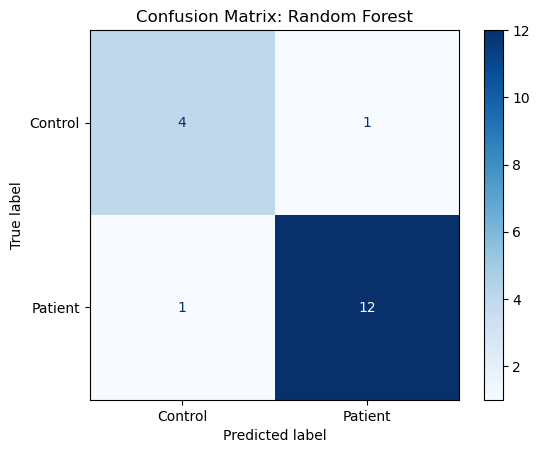

<Figure size 400x400 with 0 Axes>

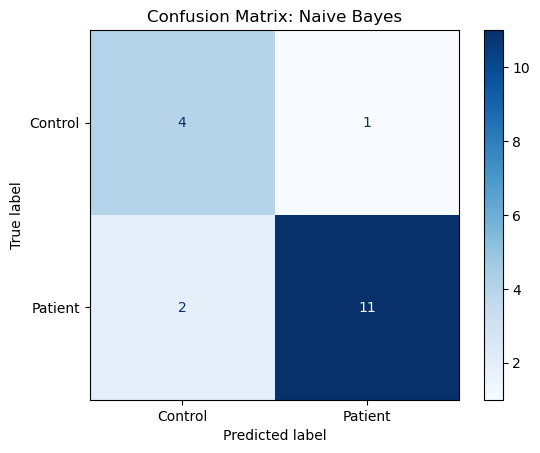

<Figure size 400x400 with 0 Axes>

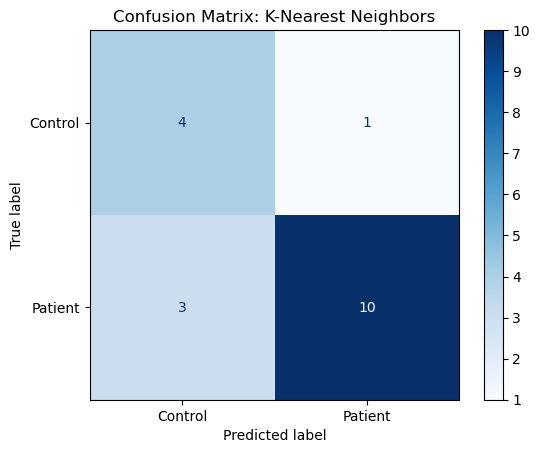

<Figure size 400x400 with 0 Axes>

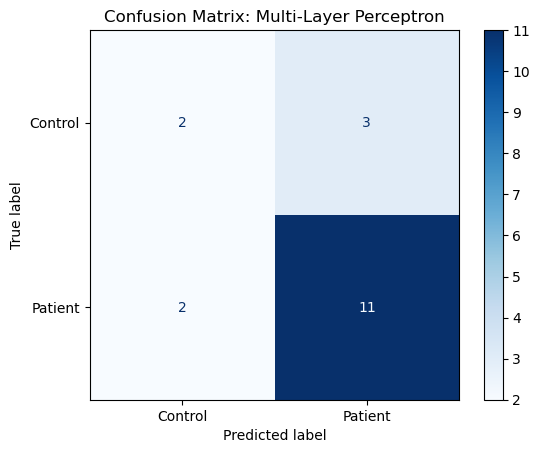

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, name):
    plt.figure(figsize=(4,4))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Control", "Patient"], cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# Example usage:
plot_confusion_matrix(rf_model, X_test, y_test, "Random Forest")
plot_confusion_matrix(nb_model, X_test, y_test, "Naive Bayes")
plot_confusion_matrix(knn_model, X_test, y_test, "K-Nearest Neighbors")
plot_confusion_matrix(mlp_model, X_test, y_test, "Multi-Layer Perceptron")

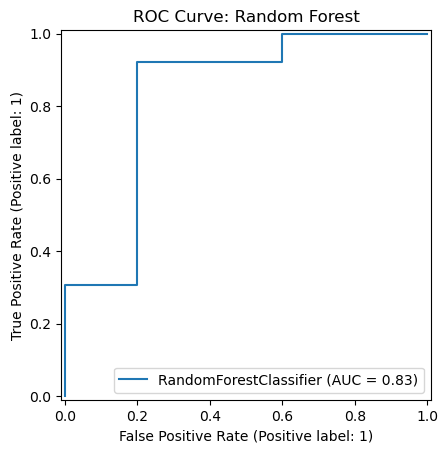

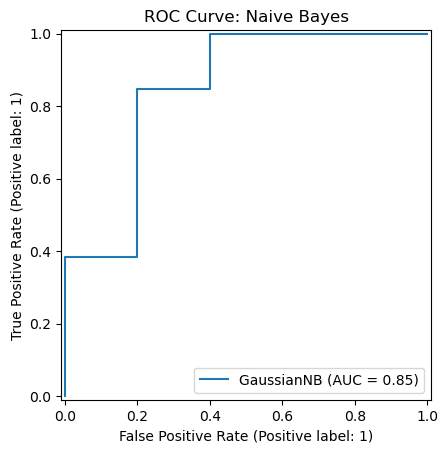

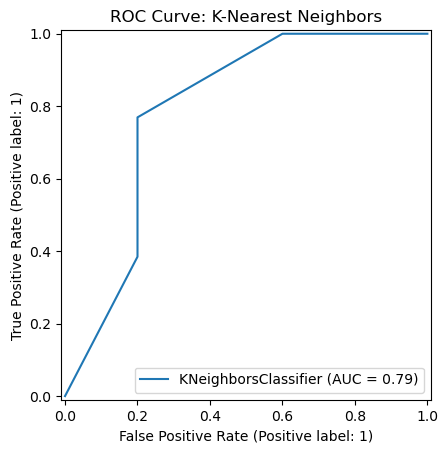

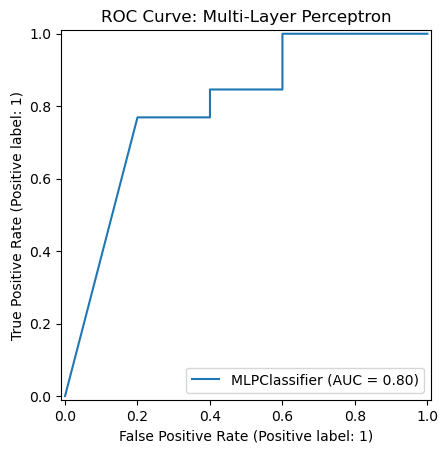

In [13]:
from sklearn.metrics import RocCurveDisplay

def plot_roc_curve(model, X_test, y_test, name):
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve: {name}")
    plt.show()

plot_roc_curve(rf_model, X_test, y_test, "Random Forest")
plot_roc_curve(nb_model, X_test, y_test, "Naive Bayes")
plot_roc_curve(knn_model, X_test, y_test, "K-Nearest Neighbors")
plot_roc_curve(mlp_model, X_test, y_test, "Multi-Layer Perceptron")


## Results Interpretation

- **Random Forest** achieved the highest accuracy and balanced precision/recall, suggesting it best captures the non-linear relationships in the data.
- **Naive Bayes** showed competitive ROC AUC but slightly lower accuracy, highlighting its simplicity and effectiveness for probabilistic classification.
- **K-Nearest Neighbors** performed moderately well but showed more variance in predictions, which may be due to small sample size and class imbalance.
- **MLP** improved with tuning but still struggled with limited data, underscoring the challenges of neural networks on small datasets.

Overall, feature importance analysis revealed strong signals in Zung SDS, BDI, and rumination measures, consistent with their clinical relevance in depression.
